# cygnus-cache

Analyze cache behavior of Cygnus / Best Fixed Offset (BFO).


In [1]:
from importlib import reload

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import plots, tables
#%matplotlib widget

In [9]:
# Knobs
paths = {
    'degree1_fixed_offset': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_fixed_offset.csv', # Different fixed offsets (-64 to +63)
    'degree1_featureless_tuned_nozeroaction': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_featureless_tuned_nozeroaction.csv',
}

suites = [
    #('spec06', 'one_phase'), #('spec06', 'weighted'),
    #('gap', 'one_phase'),
    ('google', 'one_phase')
]
features = [{'Delta_Path', 'PC_Delta'}]
dpi = 150

# Plots (suites)
Fix prefetch degree to 1 for everything.

In [4]:
from importlib import reload
from utils import utils
reload(tables)
reload(utils)
dfs = {
    'degree1_fixed_offset': tables.load_stats_csv_next_line(paths['degree1_fixed_offset']),
    'degree1_featureless_tuned_nozeroaction': tables.load_stats_csv(paths['degree1_featureless_tuned_nozeroaction'], ['cygnus', 'bo'], prefetchers_level='l2'),
}

In [14]:
def get_bfo_offset_choices(dfs):
    """Return the offset that provides the best IPC for each run.
    """
    trace_offset_choices = {}

    for run in dfs['best'].run_name.unique():
        bfo_ipc = dfs['best'][dfs['best'].run_name == run].ipc.max()
        for k, v in dfs.items():
            tr_dfs = v[v.run_name == run]
            k_ipc = tr_dfs.ipc.max()
            if k_ipc == bfo_ipc and k != 'best':
                trace_offset_choices[run] = k
    return trace_offset_choices

def get_cygnus_offset_choices(dfs):
    """Return the offset with the largest Q-value for Cygnus for each run.
    """
    trace_qv_offsets = {}
    trace_chosen_offsets = {}
    trace_str_offsets = {}
    for run in dfs['cygnus'].run_name.unique():
        path = dfs['cygnus'][dfs['cygnus'].run_name == run].path.iloc[0]
        
        with open(path) as f:
            qvs, chosen = {}, {}
            for line in f:
                if 'Q: ' in line:
                    key = line.split()[0]
                    #qvs[key] = float(line.split()[2])
                    chosen[key] = int(line.split()[5])
   
        #trace_qv_offsets[run] = max(zip(qvs.values(), qvs.keys()))[1]
        trace_chosen_offsets[run] = max(zip(chosen.values(), chosen.keys()))[1]
        trace_str_offsets[run] = f'{trace_chosen_offsets[run]}' #f'{trace_qv_offsets[run]}/{trace_chosen_offsets[run]}'

    return trace_str_offsets

In [15]:
offset_annotations = {
    'Cygnus L2': get_cygnus_offset_choices(dfs['degree1_featureless_tuned_nozeroaction']),
    'BFO L2': get_bfo_offset_choices(dfs['degree1_fixed_offset']),
}

## L2/L3 hit rates

In [7]:
def get_llc_hrs(df):
    return df.rename(columns={'LLC_hit_rate': 'hit_rate'})

def get_l2_hrs(df):
    return df.rename(columns={'L2C_hit_rate': 'hit_rate'})

=== google one_phase ===


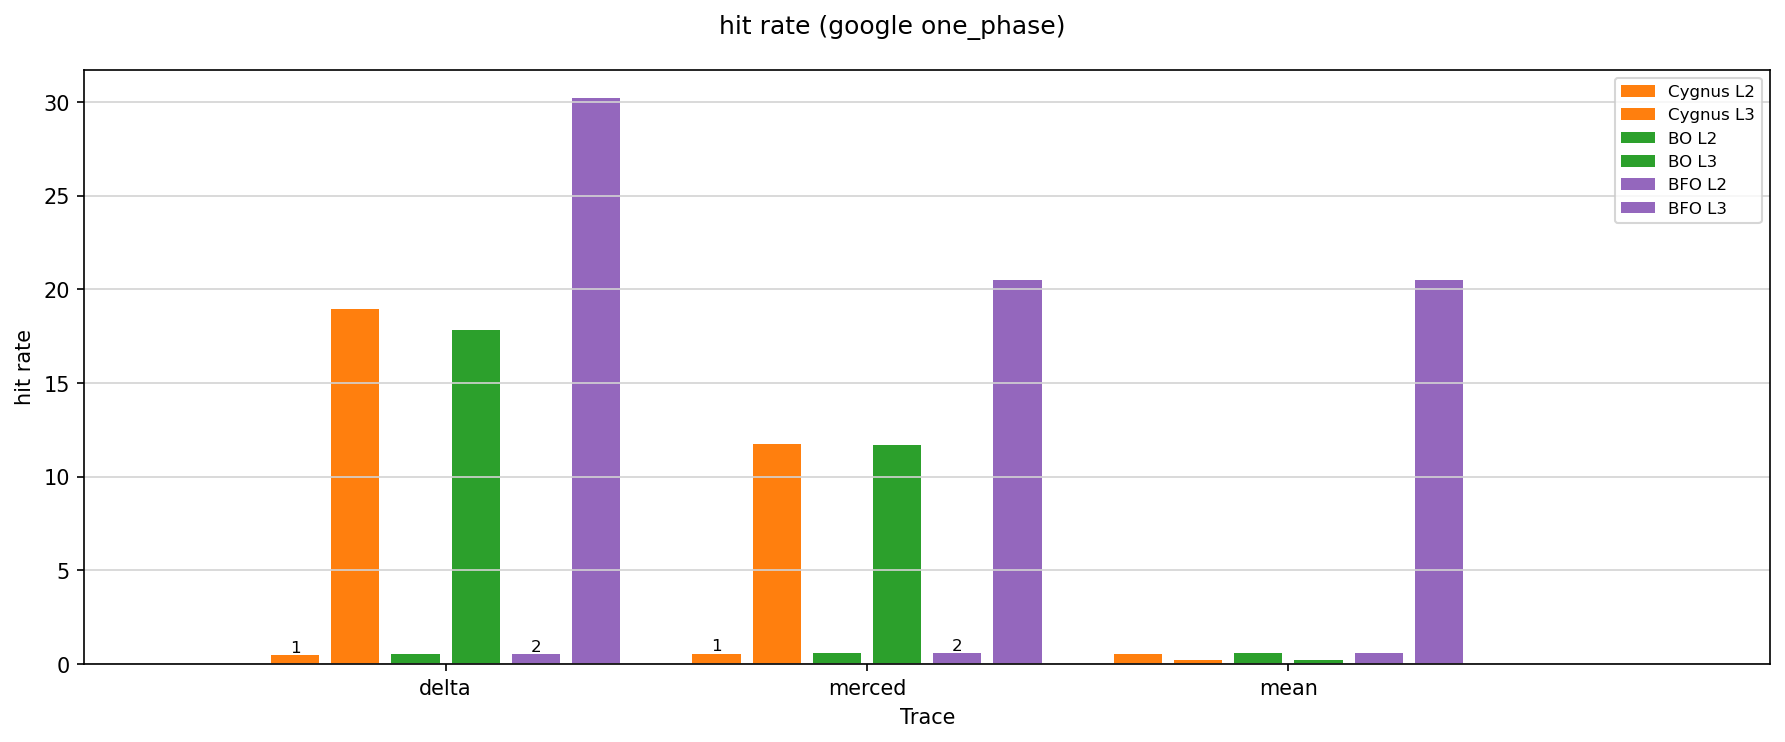

In [16]:
hit_rate_df = {
    'Cygnus L2': get_l2_hrs(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'Cygnus L3': get_llc_hrs(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'BO L2': get_l2_hrs(dfs['degree1_featureless_tuned_nozeroaction']['bo']),
    'BO L3': get_llc_hrs(dfs['degree1_featureless_tuned_nozeroaction']['bo']),
    'BFO L2': get_l2_hrs(dfs['degree1_fixed_offset']['best']),
    'BFO L3': get_llc_hrs(dfs['degree1_fixed_offset']['best']),
}

hit_rate_colors = {
    'Cygnus L2': 'C1',
    'Cygnus L3': 'C1',
    'BO L2': 'C2',
    'BO L3': 'C2',
    'BFO L2': 'C4',
    'BFO L3': 'C4',
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    #'loc': 'upper left',
    #'bbox_to_anchor': (0, 1),
}
plots.plot_everything(hit_rate_df, suites=suites, metrics=['hit_rate'],
                      legend_kwargs=legend_kwargs, dpi=dpi, colors=hit_rate_colors,
                      annotations=offset_annotations, figsize=(12,5))

## L1/L2/L3 hit counts

In [17]:
def get_l1_hits(df):
    return df.rename(columns={'L1D_hits': 'hits'})

def get_l2_hits(df):
    return df.rename(columns={'L2C_hits': 'hits'})

def get_llc_hits(df):
    return df.rename(columns={'LLC_hits': 'hits'})

def get_llc_misses(df):
    return df.rename(columns={'LLC_misses': 'hits'})

=== google one_phase ===


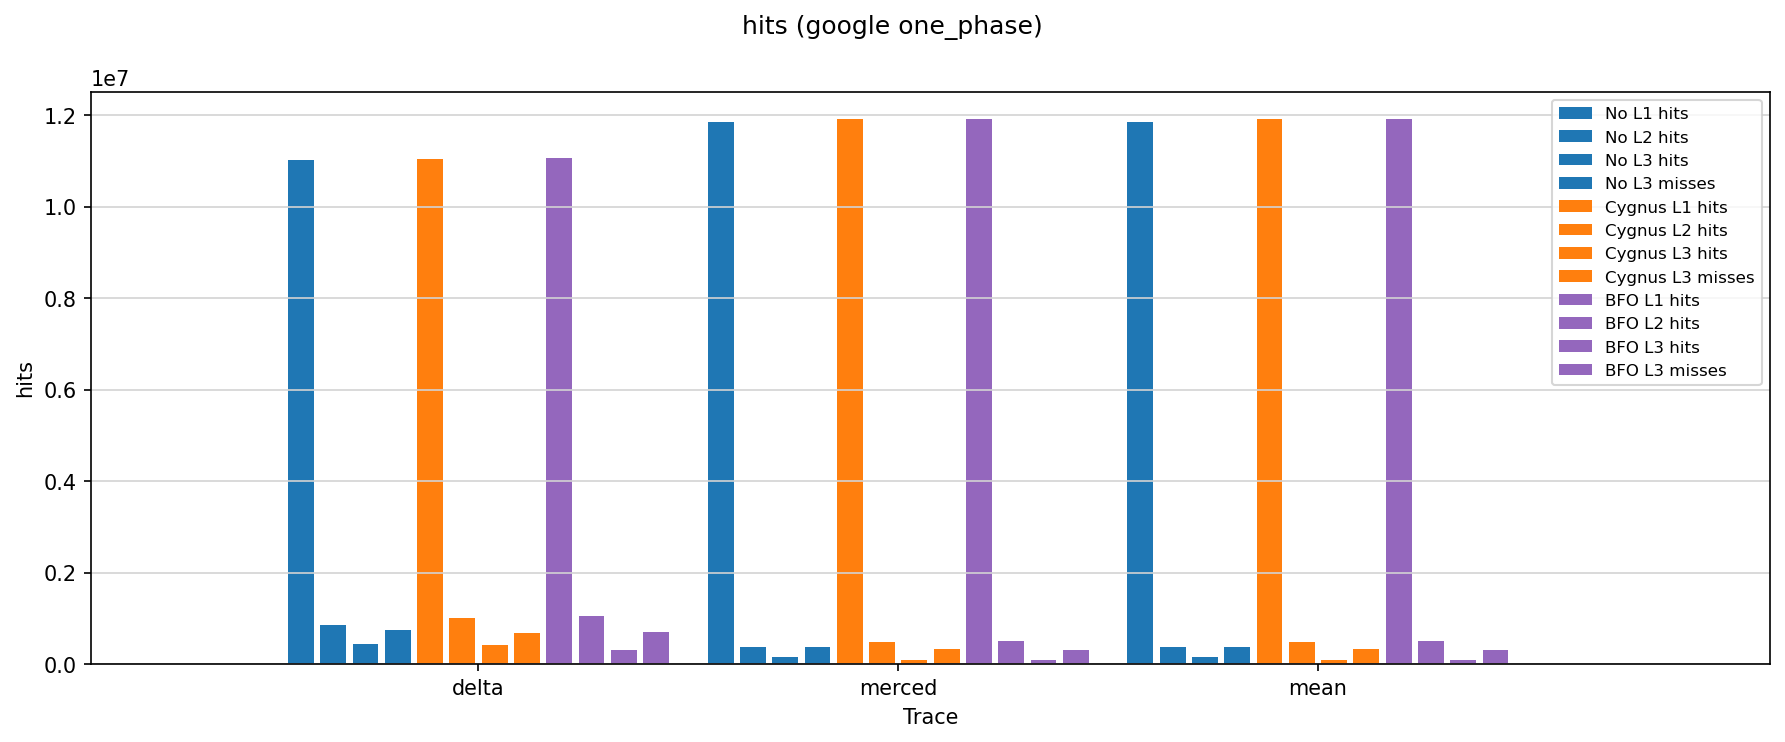

In [20]:
hit_counts_df = {
    'No L1 hits': dfs['degree1_fixed_offset']['best'].rename(columns={'L1D_hits_baseline': 'hits'}),
    'No L2 hits': dfs['degree1_fixed_offset']['best'].rename(columns={'L2C_hits_baseline': 'hits'}),
    'No L3 hits': dfs['degree1_fixed_offset']['best'].rename(columns={'LLC_hits_baseline': 'hits'}),
    'No L3 misses': dfs['degree1_fixed_offset']['best'].rename(columns={'LLC_misses_baseline': 'hits'}),
    'Cygnus L1 hits' : get_l1_hits(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'Cygnus L2 hits' : get_l2_hits(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'Cygnus L3 hits': get_llc_hits(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'Cygnus L3 misses': get_llc_misses(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'BFO L1 hits' : get_l1_hits(dfs['degree1_fixed_offset']['best']),
    'BFO L2 hits' : get_l2_hits(dfs['degree1_fixed_offset']['best']),
    'BFO L3 hits': get_llc_hits(dfs['degree1_fixed_offset']['best']),
    'BFO L3 misses': get_llc_misses(dfs['degree1_fixed_offset']['best']),
}
hit_counts_colors = {
    'Cygnus L1 hits' : 'C1',
    'Cygnus L2 hits' : 'C1',
    'Cygnus L3 hits': 'C1',
    'Cygnus L3 misses': 'C1',
    'No L1 hits': 'C0',
    'No L2 hits': 'C0',
    'No L3 hits': 'C0',
    'No L3 misses': 'C0',
    'BFO L1 hits' : 'C4',
    'BFO L2 hits' : 'C4',
    'BFO L3 hits': 'C4',
    'BFO L3 misses': 'C4',
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    #'loc': 'upper left',
    #'bbox_to_anchor': (0, 1),
}
plots.plot_everything(hit_counts_df, suites=suites, metrics=['hits'],
                      legend_kwargs=legend_kwargs, dpi=dpi, colors=hit_counts_colors,
                      figsize=(12,5))


# Tables

## L2/L3 hit rates

In [27]:
tables.table_everything(hit_rate_df, metrics=['hit_rate'])

=== spec06 one_phase ===
hit_rate


,Cygnus L2,Cygnus L3,BO L2,BO L3,BFO L2,BFO L3
run_name,,,,,,
GemsFDTD_109B,0.790062,0.908511,0.494686,0.183565,NaN,NaN
astar_313B,0.335385,5.620253,0.351738,5.690612,NaN,NaN
bwaves_1861B,0.891171,0.008555,0.897162,0.048276,NaN,NaN
cactusADM_734B,0.719969,0.547546,0.701725,0.459052,NaN,NaN
lbm_94B,0.498352,0.070348,0.475993,0.062065,NaN,NaN
leslie3d_1116B,0.613603,0.058261,0.463274,0.047772,NaN,NaN
leslie3d_94B,0.666056,20.926898,0.610516,18.113699,NaN,NaN
libquantum_1210B,0.795879,0.000000,0.744629,0.000000,0.389993,0.000000
mcf_46B,0.352540,30.730353,0.319805,29.872819,0.417787,33.945072


## L1/L2/L3 hit counts

In [25]:
tables.table_everything(hit_counts_df, metrics=['hits'])

=== spec06 one_phase ===
hits


,No L1 hits,No L2 hits,No L3 hits,No L3 misses,Cygnus L1 hits,Cygnus L2 hits,Cygnus L3 hits,Cygnus L3 misses,BFO L1 hits,BFO L2 hits,BFO L3 hits,BFO L3 misses
run_name,,,,,,,,,,,,
libquantum_1210B,864899.0,0.0,0.0,1380939.0,873548.0,1099060.0,0.0,281879.0,889154.0,538557.0,0.0,842383.0
mcf_46B,7895090.0,1410175.0,875408.0,3368028.0,7899096.0,1993077.0,1124836.0,2535506.0,7919600.0,2361971.0,1117318.0,2174229.0
mean,7895090.0,1410175.0,875408.0,3368028.0,11074354.0,555037.0,22078.0,56733.0,7919600.0,2361971.0,1117318.0,2174229.0
GemsFDTD_109B,NaN,NaN,NaN,NaN,15495093.0,1516086.0,3660.0,399197.0,NaN,NaN,NaN,NaN
astar_313B,NaN,NaN,NaN,NaN,15145446.0,942395.0,104958.0,1762538.0,NaN,NaN,NaN,NaN
bwaves_1861B,NaN,NaN,NaN,NaN,20175087.0,1148677.0,12.0,140264.0,NaN,NaN,NaN,NaN
cactusADM_734B,NaN,NaN,NaN,NaN,21434416.0,421192.0,897.0,162925.0,NaN,NaN,NaN,NaN
lbm_94B,NaN,NaN,NaN,NaN,5792873.0,1170684.0,829.0,1177593.0,NaN,NaN,NaN,NaN
leslie3d_1116B,NaN,NaN,NaN,NaN,11575492.0,997600.0,366.0,627840.0,NaN,NaN,NaN,NaN
